In [1]:
#---This program is used to forecast 1 week CDRs based on 55 previous days' data

#---Install these bibs so the program works properly
import pandas as pd
import numpy as np
from numpy import loadtxt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
#--Loading Cell_ID vector, whose elements tell from which ID the matrix_TS row is the corresponding time-series

Cell_ID = loadtxt('ID_labels.csv', delimiter=',') 
df = pd.read_csv('matrixTS.csv',header=None)
df.head(6)

,0,1,2,3,4,5,6,7,8,9,...,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487
0,13,11,8,7,8,9,11,12,13,18,...,23.0,17.0,20.0,16.0,16.0,18.0,19.0,21.0,17.0,13.0
1,13,11,10,7,6,9,11,11,13,17,...,22.0,15.0,20.0,15.0,15.0,18.0,20.0,19.0,17.0,13.0
2,15,11,9,11,9,8,12,18,23,31,...,6.0,9.0,9.0,11.0,8.0,7.0,7.0,8.0,7.0,5.0
3,12,11,7,9,6,6,8,15,12,23,...,14.0,12.0,17.0,17.0,15.0,14.0,12.0,13.0,14.0,10.0
4,10,8,11,7,8,8,12,16,16,16,...,28.0,26.0,23.0,26.0,27.0,19.0,18.0,20.0,14.0,18.0
5,11,8,7,6,8,8,6,7,12,14,...,14.0,13.0,12.0,14.0,14.0,12.0,12.0,16.0,11.0,10.0


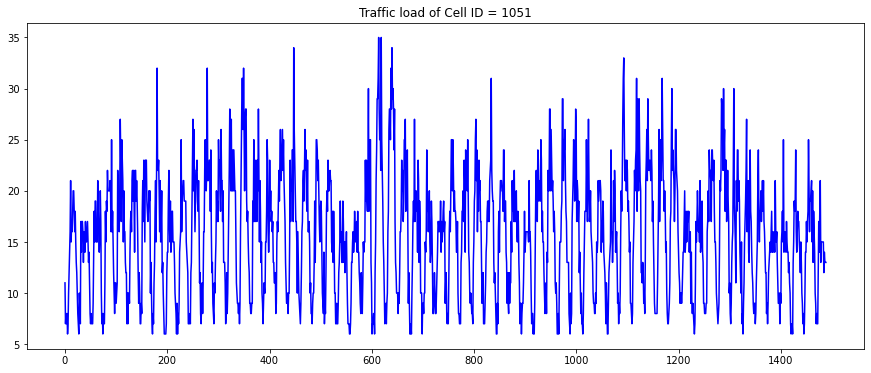

In [3]:
#--Defines the Cell ID to be forecasted and plots the corresponding time-series

matrix = df.to_numpy()

ID=60
time_series = matrix[ID][:]
hour = np.linspace(0,24*62,24*62)

plt.figure(figsize=(15,6))
plt.title('Traffic load of Cell ID = %d' % (Cell_ID[60])) 
plt.plot(hour,time_series,'b')

In [4]:
#--Decomposing the signal according to Classical Decomposition approach: formulas in Survey Paper

S = 24 #--period length
q = int(S/2)
m_hat = np.zeros(q)
m_hat = m_hat.tolist()

for t in range(q,len(time_series)-q):
    aux = (0.5*time_series[t-q]+sum(time_series[t-q+1:t+q])+0.5*time_series[t+q])/S
    m_hat.append(aux)    

vec_aux = []
w = []
vec_k = np.linspace(S,2*S-1,S).astype(int)
vec_k = vec_k.tolist()

for i in vec_k:
    while i<(len(time_series)-q):
        vec_aux.append(time_series[i]-m_hat[i])
        i=i+S
    w.append(np.mean(vec_aux))
    vec_aux = []

vec_s_hat = []
s_hat = []
mean_w = np.mean(w)

for k in range(0,S):
    aux = w[k]-mean_w
    vec_s_hat.append(aux)

for i in range(0,int(len(time_series)/S)):
    s_hat.append(vec_s_hat)

s_hat = np.array(s_hat)
s_hat = s_hat.flatten() 

m = []
vec_aux = []
for i in range(0,len(time_series)):
    for c in range(-q,q+1):
        if (i+c) < 0:
           vec_aux.append([time_series[0]])
        elif (i+c) >= len(time_series):
           vec_aux.append([time_series[len(time_series)-1]])
        else:
           vec_aux.append([time_series[i+c]]) 
    
    vec_aux = np.array(vec_aux)
    m.append(sum(vec_aux)/(S+1))
    vec_aux = []

r = []
d = time_series-s_hat
m = np.array(m)
s = s_hat.flatten()

for i in range(0,len(time_series)):
    r.append(time_series[i]-s_hat[i]-m[i])
r = np.array(r)
 


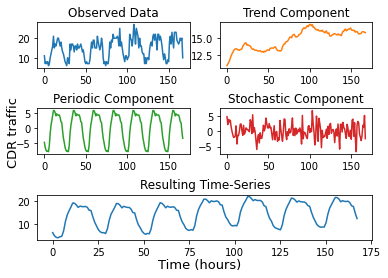

<Figure size 432x288 with 0 Axes>

In [5]:
plot_size = 24*7 # decides the length to be plotted

trend_periodic = []
for i in range(0,len(time_series)):
    trend_periodic.append(m[i]+s[i]) 
trend_periodic = np.array(trend_periodic)

fig = plt.figure()
# Set common labels
fig.text(0.5, 0.04, 'Time (hours)', ha='center', va='center',fontsize=13)
fig.text(0.07, 0.5, 'CDR traffic', ha='center', va='center', rotation='vertical',fontsize=13)

ax1 = plt.subplot(321)
ax1.plot(hour[0:plot_size], time_series[0:plot_size])
ax1.set_title('Observed Data')

ax2 = plt.subplot(322)
ax2.plot(hour[0:plot_size], m[0:plot_size], 'tab:orange')
ax2.set_title('Trend Component')
#ax2.set_yticks([])

ax3 = plt.subplot(323)
ax3.plot(hour[0:plot_size], s[0:plot_size], 'tab:green')
ax3.set_title('Periodic Component')
#ax3.set_yticks([])

ax4 = plt.subplot(324)
ax4.plot(hour[0:plot_size], r[0:plot_size], 'tab:red')
ax4.set_title('Stochastic Component')
#ax4.set_yticks([])

ax5 = plt.subplot(3,2,(5,6))
ax5.plot(hour[0:plot_size],trend_periodic[0:plot_size])
ax5.set_title('Resulting Time-Series')

plt.subplots_adjust(hspace=0.9,wspace=0.2)
plt.show() 
plt.draw()


## Defining training and test data sets

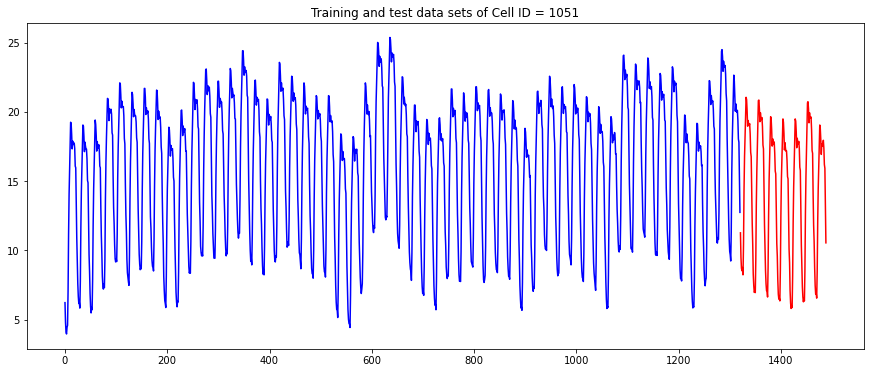

In [6]:
training_size = 55 # in days
ts_training = trend_periodic[0:24*training_size]
hour_training = hour[0:24*training_size]

ts_test = trend_periodic[24*training_size:]
hour_test = hour[24*training_size:]

plt.figure(figsize=(15,6))
plt.title('Training and test data sets of Cell ID = %d' % (Cell_ID[60])) 
plt.plot(hour_training,ts_training,'b')
plt.plot(hour_test,ts_test,'r')

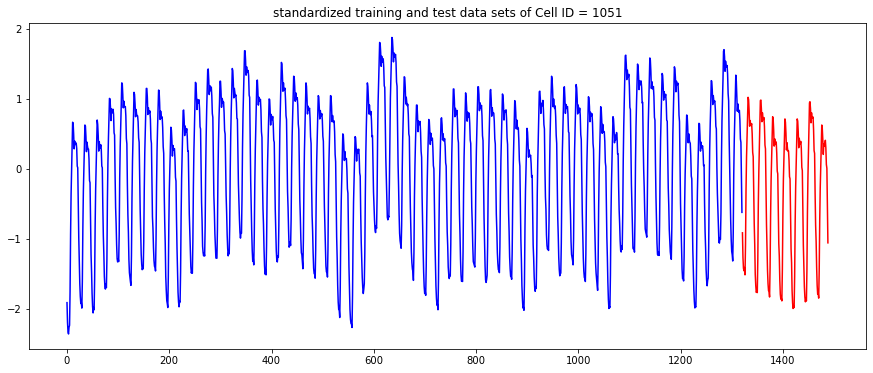

In [7]:
#---Standardization of the CDR time-series

ts_training_mean = ts_training.mean()
ts_training_std = ts_training.std() 

ts_training_standardized = (ts_training - ts_training_mean) / ts_training_std
ts_test_standardized = (ts_test - ts_training_mean) / ts_training_std

plt.figure(figsize=(15,6))
plt.title('standardized training and test data sets of Cell ID = %d' % (Cell_ID[60])) 
plt.plot(hour_training,ts_training_standardized,'b')
plt.plot(hour_test,ts_test_standardized,'r')

## Starting SARIMA model

In [8]:
#---Here we do a grid search on the parameters p,d,q,P,D,Q,S and select the one with smallest AIC criterion

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

AIC_vector = []
param_vector = []
param_seasonal_vector = []

print("Grid search in progress...")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_training_standardized,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            AIC_vector.append(results.aic)
            param_vector.append(param)
            param_seasonal_vector.append(param_seasonal)
            
        except: 
            continue

print("Grid search finished.")            
print('Arg min',np.min(AIC_vector),param_vector[np.argmin(AIC_vector)],param_seasonal_vector[np.argmin(AIC_vector)])

Grid search in progress...


C:\Users\gabri\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\gabri\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\gabri\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\gabri\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\gabri\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\gabri\anaconda3\envs\

Grid search finished.
Arg min -5273.707004650206 (1, 1, 1) (1, 0, 1, 24)


In [9]:
#--Fit model with parameters that provided the best (smallest) AIC

p = param_vector[np.argmin(AIC_vector)][0]
d = param_vector[np.argmin(AIC_vector)][1]
q = param_vector[np.argmin(AIC_vector)][2]

P = param_seasonal_vector[np.argmin(AIC_vector)][0]
D = param_seasonal_vector[np.argmin(AIC_vector)][1]
Q = param_seasonal_vector[np.argmin(AIC_vector)][2]

mod = sm.tsa.statespace.SARIMAX(ts_training_standardized,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

C:\Users\gabri\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1320
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood                2641.854
Date:                            Fri, 30 Sep 2022   AIC                          -5273.707
Time:                                    13:30:13   BIC                          -5247.883
Sample:                                         0   HQIC                         -5264.015
                                           - 1320                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8473      0.028     30.538      0.000       0.793       0.902
ma.L1         -0.6073      0.040   

Text(0, 0.5, 'CDR')

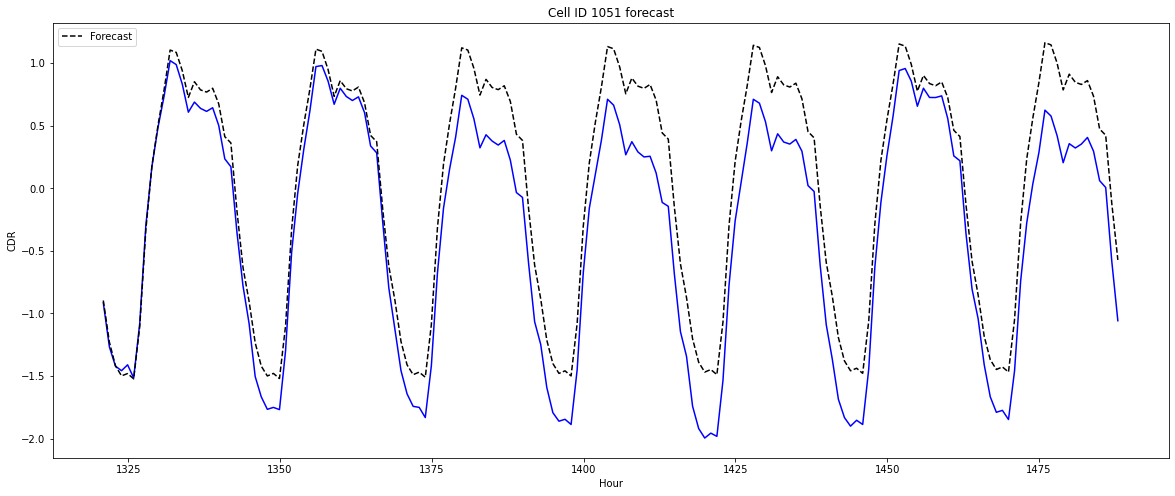

In [10]:
#---Prediction with trained model

days_predict = 7 #variable that defines how many days to forecast
pred_uc = results.get_forecast(steps=24*days_predict)
pred_ci = pred_uc.conf_int()

plt.figure(figsize=(20,8))
plt.title("Cell ID %d forecast" % (Cell_ID[60])) 
plt.plot(hour_test,ts_test_standardized,'b')
plt.plot(hour_test,pred_uc.predicted_mean,'k--',label="Forecast")
plt.legend(loc='upper left')
plt.xlabel("Hour")
plt.ylabel("CDR")

Text(0, 0.5, 'CDR')

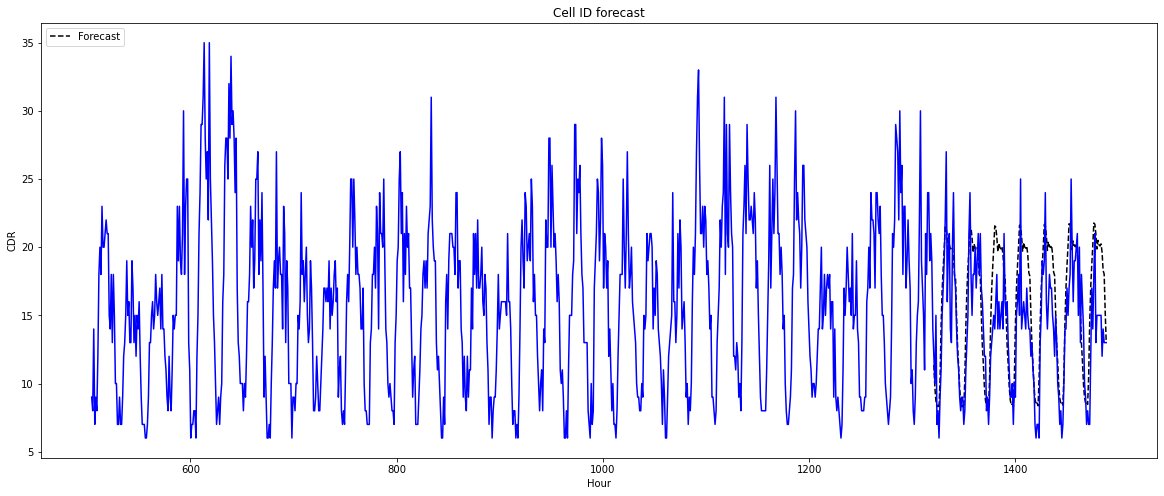

In [11]:
#--Ploting the actual result (not considering mean and std)

test_predictions = pred_uc.predicted_mean*ts_training_std+ts_training_mean

plt.figure(figsize=(20,8))
plt.title("Cell ID forecast") 

plt.plot(hour_test,test_predictions,'k--',label="Forecast")
plt.plot(hour[24*21:],time_series[24*21:],'b')

plt.legend(loc='upper left')
plt.xlabel("Hour")
plt.ylabel("CDR")

In [12]:
MAE = mean_absolute_error(time_series[24*55:], test_predictions)
MSE = mean_squared_error(time_series[24*55:], test_predictions)
print('MAE:', "%.3f" % MAE)
print('MSE:', "%.3f" % MSE)

MAE: 2.756
MSE: 11.631
